# Deep Convolutional GANs for CIFAR-10

## Introduction

This project demonstrates the implementation and training of a Deep Convolutional Generative Adversarial Network (DCGAN) on the CIFAR-10 dataset. The goal is to generate new images that mimic the style of the dataset images. 

DCGANs are a class of generative adversarial networks that use convolutional and convolutional-transpose layers in the discriminator and generator, respectively. This approach is known for producing high-quality synthetic images.

## Setup and Preprocessing

First, let's import the necessary libraries and set up our environment.


In [ ]:
!pip install -q torch torchvision altair==4.2.2 seaborn tqdm
from pathlib import Path
import tqdm

The path here is designed for colab, when using other environment this should be changed.

In [ ]:
from google.colab import drive
%load_ext google.colab.data_table
content_path = f'/content/drive/MyDrive/' 
data_path = './data/'
drive.mount('/content/drive/')
content_path = Path(content_path)

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

mean = torch.Tensor([0.4914, 0.4822, 0.4465])
std = torch.Tensor([0.247, 0.243, 0.261])
# mean = torch.Tensor([0.5, 0.5, 0.5])
# std = torch.Tensor([0.5, 0.5, 0.5])
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x, channels=None, w=None ,h=None, resize = False):

    x = unnormalize(x)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'CW_GAN'):
    os.makedirs(content_path/'CW_GAN')

GPU = True 
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

Using cuda


## Data Loading and Preprocessing

We'll start by loading the CIFAR-10 dataset and applying some basic preprocessing.

In [ ]:
batch_size = 128

transform = transforms.Compose([
     transforms.RandomHorizontalFlip(p=0.2),
     # transforms.RandomVerticalFlip(p=0.2),
     transforms.ToTensor(),
     transforms.Normalize(mean=mean, std=std),
])

cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=batch_size)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


We'll visualize a subset of the test set:

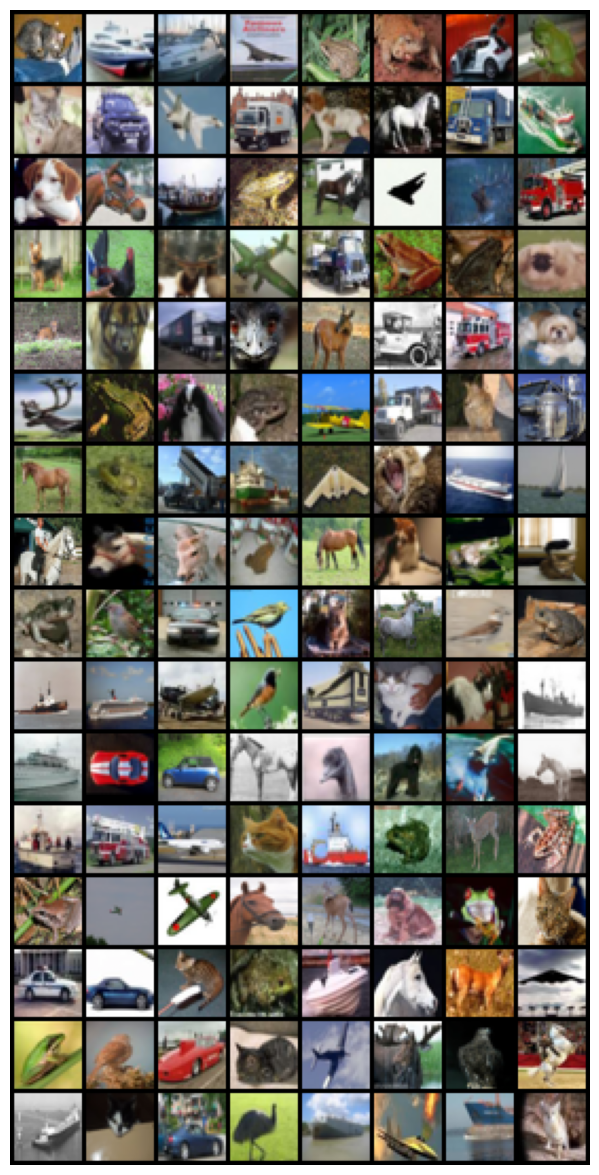

In [ ]:
samples, _ = next(iter(loader_test))

samples = samples.cpu()
samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                        value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize = (15,15))
plt.axis('off')
show(samples)

## Model Definition
Define hyperparameters and the model

In [ ]:
num_epochs = 70
learning_rate = 4e-4
latent_vector_size = 32

# Other hyperparams
g_feature_size = 48
d_feature_size = 64
channels = 3
leak_neg_slope = 0.2

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.generate = nn.Sequential(
            nn.ConvTranspose2d(latent_vector_size, g_feature_size * 4,
                               kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(g_feature_size * 4),
            nn.ReLU(True),
            # nn.Dropout2d(0.5),
            nn.ConvTranspose2d(g_feature_size * 4, g_feature_size * 2,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(g_feature_size * 2),
            nn.ReLU(True),
            # nn.Dropout2d(0.5),
            nn.ConvTranspose2d(g_feature_size * 2, g_feature_size,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(g_feature_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(g_feature_size, channels,
                               kernel_size=4, stride=2, padding=1, bias=False),
            # nn.Tanh()
        )


    def forward(self, z):
        out = self.generate(z)
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminate = nn.Sequential(
            nn.Conv2d(channels, d_feature_size,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(d_feature_size),
            nn.LeakyReLU(leak_neg_slope, True),

            nn.Conv2d(d_feature_size, d_feature_size * 2,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(d_feature_size * 2),
            nn.LeakyReLU(leak_neg_slope, True),

            nn.Conv2d(d_feature_size * 2, d_feature_size * 4,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(d_feature_size * 4),
            nn.LeakyReLU(leak_neg_slope, True),

            nn.Conv2d(d_feature_size * 4, 1,
                      kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )


    def forward(self, x):
        out = self.discriminate(x).view(-1, 1).squeeze(1)

        return out


## Model Initialization and Parameters

In this project, the `weights_init` method is applied to initialize the weights of the Generator and Discriminator networks, which can potentially facilitate the training process and convergence.


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 469920
Generator(
  (generate): Sequential(
    (0): ConvTranspose2d(32, 192, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(48, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)


Total number of parameters in Discriminator is: 663424
Discriminator(
  (discriminate): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fals

## Training the Model 

In [ ]:
criterion = nn.BCELoss()

def loss_function(out, target):
    loss = criterion(out, target)
    return loss

<h3>Choose and initialize optimizers</h3>

In [ ]:
beta1 = 0.5
gamma1 = 0.95

optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate*0.5, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))

schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size = 1, gamma = gamma1)
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size = 2, gamma = gamma1)

<h5> Define fixed input vectors to monitor training and mode collapse. </h5>

In [ ]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

#### Training Loop

* errD: Loss of Discriminator after being trained on real and fake instances
* errG: Loss of Generator
* D_x: Output of Discriminator for real images
* D_G_z1: Output of Discriminator for fake images (When Generator is not being trained)
* D_G_z2: Output of Discriminator for fake images (When Generator is being trained)

In [ ]:
train_losses_G = []
train_losses_D = []

for epoch in range(num_epochs):
    with tqdm.tqdm(loader_train, unit="batch") as tepoch:
        for i, data in enumerate(tepoch):
            train_loss_D = 0
            train_loss_G = 0

            # train with real
            model_D.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), 1., dtype=torch.float, device=device)
            output = model_D(real_cpu).view(-1)
            errD_real = loss_function(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            noise = torch.randn(b_size, latent_vector_size, 1, 1, device=device)
            fake = model_G(noise)
            label.fill_(0.)  # fake labels are zero
            output = model_D(fake.detach()).view(-1)
            errD_fake = loss_function(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            model_G.zero_grad()
            label.fill_(1.)  # fake labels are real for generator cost
            output = model_D(fake).view(-1)
            errG = loss_function(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            train_loss_D += errD.item()
            train_loss_G += errG.item()

            # Logging
            if i % 50 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}", D_x=D_x,
                                  Loss_D=errD.item(), Loss_G=errG.item())

    if schedulerD is not None and schedulerG is not None:
        schedulerD.step()
        schedulerG.step()

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), content_path/'CW_GAN/real_samples.png')
    with torch.no_grad():
        fake = model_G(fixed_noise)
        save_image(denorm(fake.cpu()).float(), str(content_path/'CW_GAN/fake_samples_epoch_%03d.png') % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))

# save  models
# if your discriminator/generator are conditional you'll want to change the inputs here
torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), content_path/'CW_GAN/GAN_G_model.pth')
torch.jit.save(torch.jit.trace(model_D, (fake)), content_path/'CW_GAN/GAN_D_model.pth')

Epoch 69: 100%|██████████| 391/391 [00:25<00:00, 15.41batch/s, D_G_z=0.291/0.303, D_x=0.651, Loss_D=0.828, Loss_G=1.34]


## Results

### Generator samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


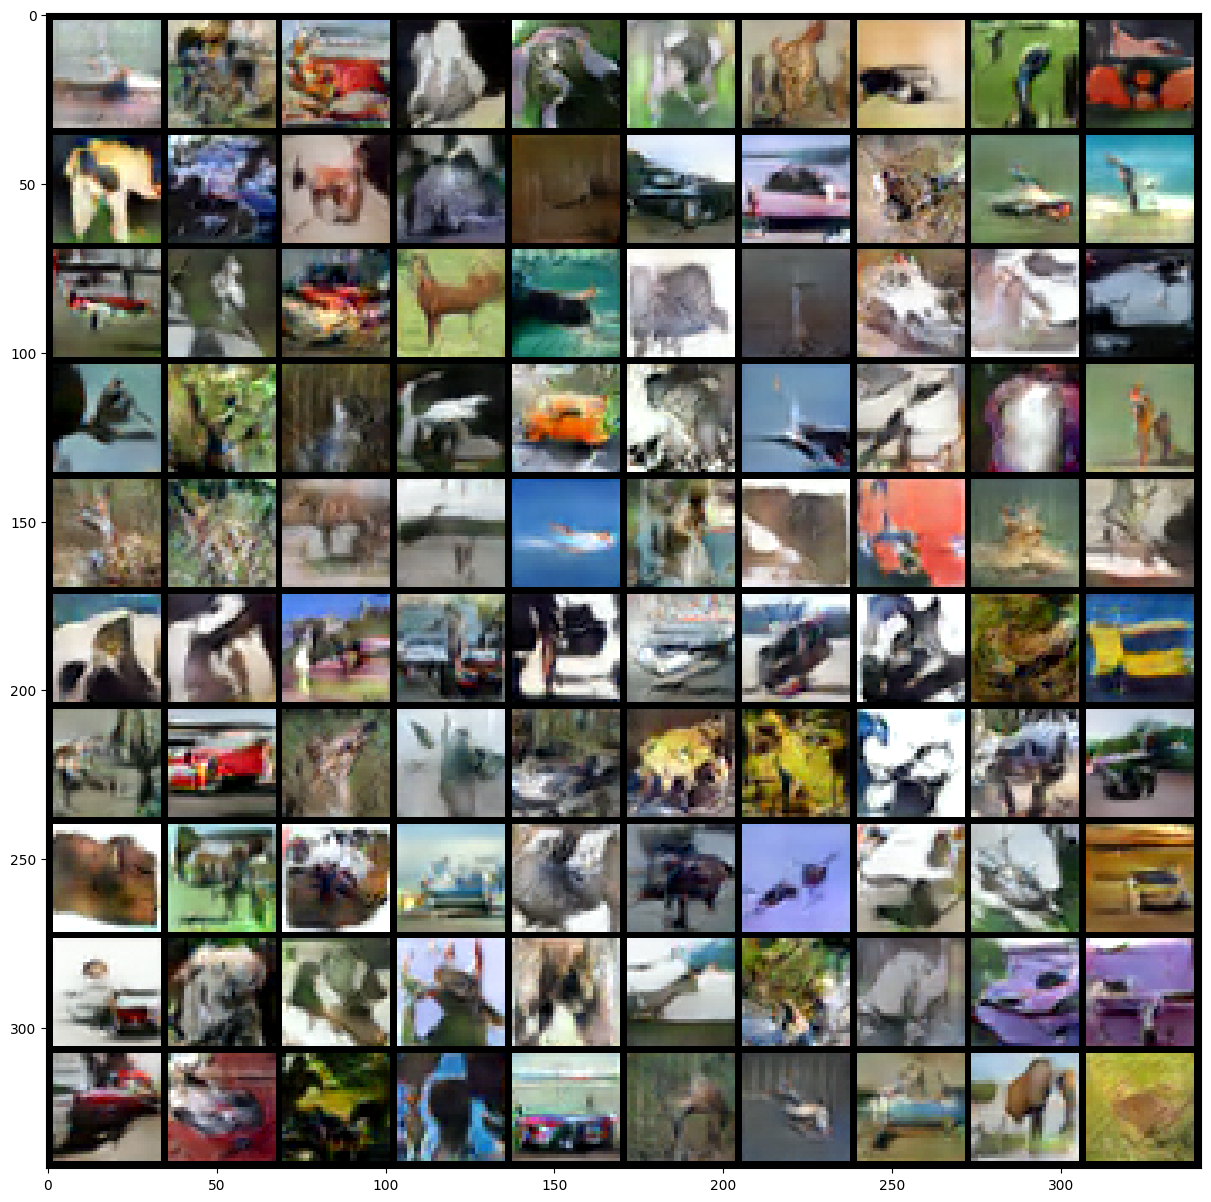

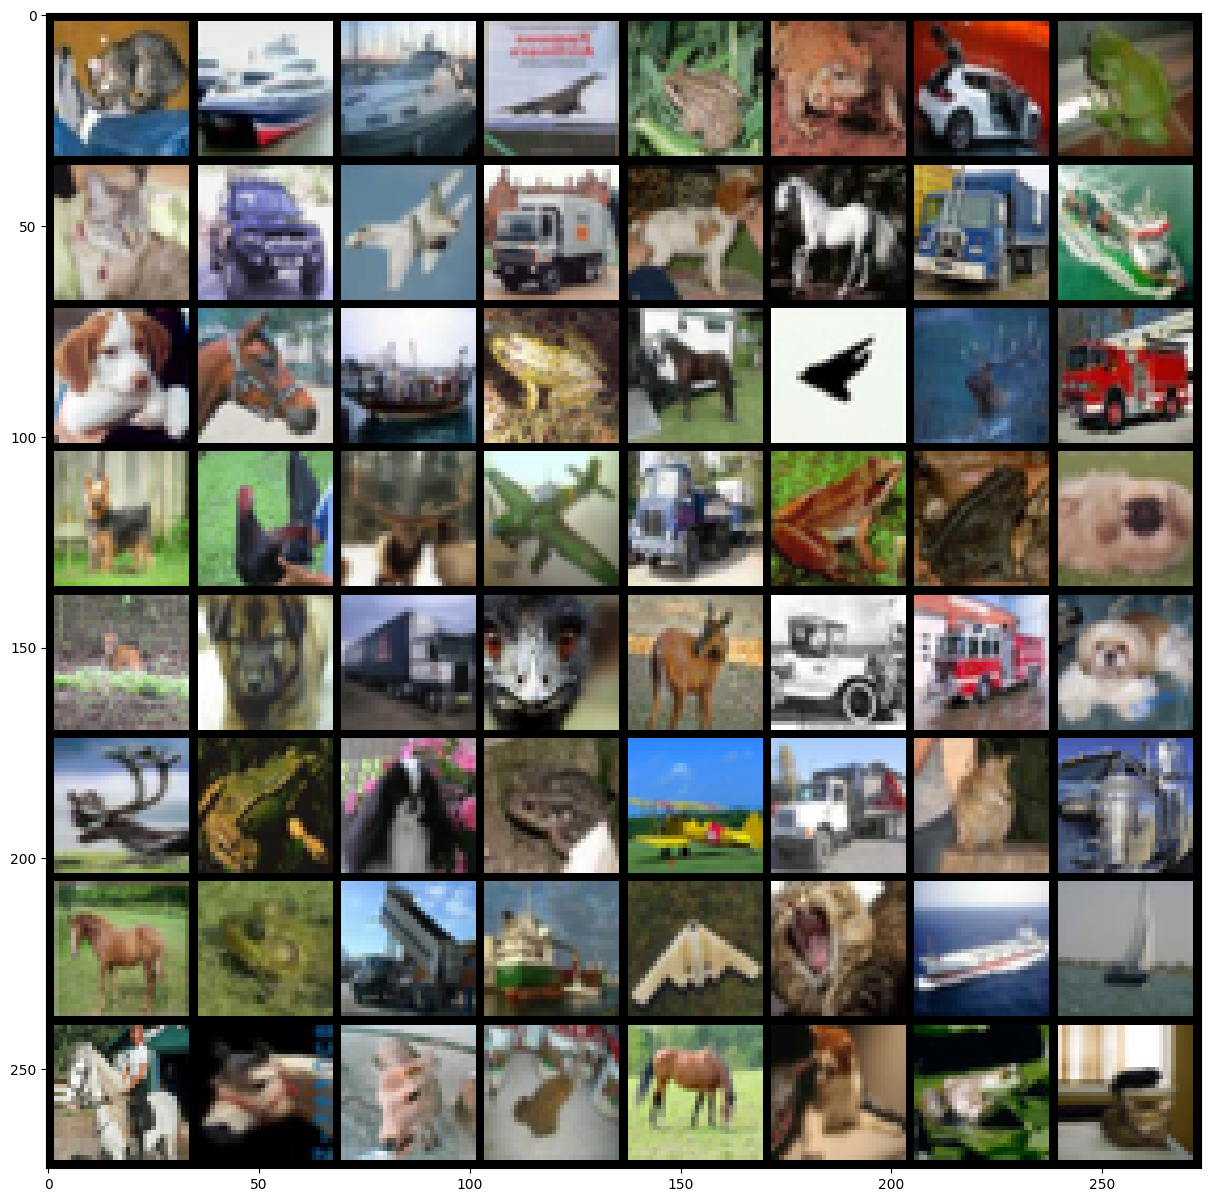

In [ ]:
input_noise = torch.randn(100, latent_vector_size, 1, 1, device=device)
with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:100], nrow=10, padding=2, normalize=False,
                        value_range=None, scale_each=False, pad_value=0)
    plt.figure(figsize=(15,15))
    save_image(generated, content_path/'CW_GAN/Teaching_final.png')
    show(generated) # note these are now class conditional images columns rep classes 1-10

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:64, :, :, :]
# visualize the original images of the last batch of the test set for comparison
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
show(img)

### Loss Curves

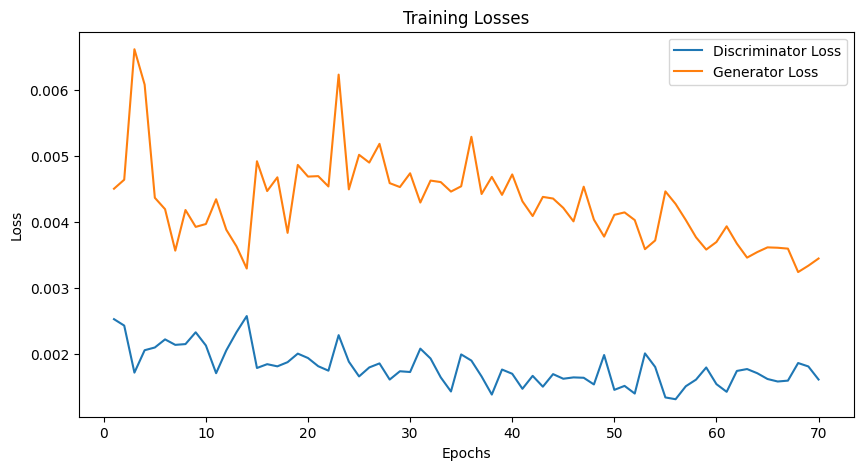

In [ ]:
import matplotlib.pyplot as plt

# Assuming train_losses_D and train_losses_G are lists of losses per epoch.
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses_D, label='Discriminator Loss')
plt.plot(epochs, train_losses_G, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The loss curves look sensible but there are some potential issues.

The discriminator loss(blue line) is steadily decreasing, which means the discriminator is improving over time at distinguishing real images from fake ones. However, if the loss continues to decrease and gets too close to zero, it means that the discriminator is too strong compared to the generator, leading to an imbalance in training.

The Generator Loss is fluctuating with a downward trend. This could indicate that the generator is struggling to find strategies to consistently fool the discriminator, or it might be that the discriminator is too strong and the generator is having difficulty improving. However, it is decreasing which means it is improving and becoming better at cheating the discriminator.

For discriminator loss, we expect to see it start relatively high as the discriminator is initially learning to distinguish between real and fake images. Over time, we would hope to see the discriminator loss decrease, indicating it's getting better at its task. However, it should not reach zero because this would imply the discriminator is too confident and might be overfitting.

For generator loss, we expect to see it starts high as it struggles to fool the discriminator. Over time, we would want the generator loss to gradually decrease, indicating that it is getting better at generating images that the discriminator classifies as real. Fluctuations are normal, as the generator tries different strategies to improve.

A balanced and steady decline in both losses is desired in GAN training. If the discriminator loss becomes too low, it could mean the discriminator is winning the game, and the generator might not be improving effectively. Conversely, if the generator loss is consistently low and the discriminator loss is high, it could indicate the generator is too strong, and the discriminator is not learning effectively.

## Conclusion

This project showcases the basic implementation of a DCGAN on the CIFAR-10 dataset. Through this process, we've seen how GANs can be trained to generate new images that resemble a given dataset. For further improvement, experimenting with different architectures, loss functions, and training techniques could yield better results.